# Toeplitz and Circulant Matrix Eigenvalue Spectra

The Eigenvalues of Circulant and Toeplitz matrices are directly related to the Fourier transform. This notebook demonstrates this relation using some simple example covariance matrices.

In [304]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import jn
from scipy.stats.mstats import gmean

## the 1d case: Toeplitz and Circulant matrices

We initialize two covariance matrices that both use a Bessel function as 1d covariance function, i.e. the covariance of a point pair is given by 0-order Bessel function evaluated at the distance of the two points.

We consider the case where the point pair distance is computed with non-periodic and periodic boundaries. The corresponding covariance matrices differ slightly. Only in the periodic case, we get a True circulant matrix, where every row is a shifted copy of the previous. On the other hand, in the non-periodic case, each point 'sees' a different part of the Bessel function. It's covariance function has Toeplitz, but not circulant form.

After the covariance matrices are computed, they are decomposed into their eigenvalue/vector spectrum and displayed .

[(0, 55),
 (0, 55),

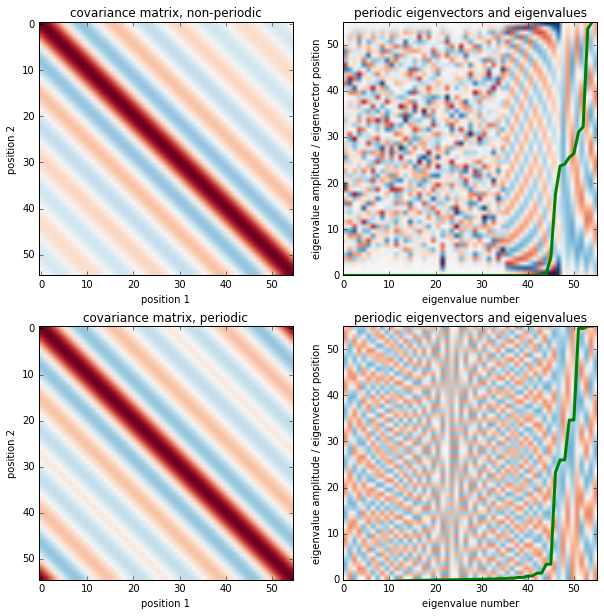

In [305]:
def get_1dcovariance_matrix(nx, frequency, boundary=None):
    width = 1.
    x = np.arange(0., width, 1./nx)
    distances = np.abs(x[:, None] - x[None, :])
    if boundary == 'periodic':
        iwrap = distances > width/2.
        distances[iwrap] = width - distances[iwrap]
    covariance = jn(0, frequency * distances)
    return covariance

# get covariance matrices
nx = 55
frequency = 25
covariance = get_1dcovariance_matrix(nx, frequency)
evals, evecs = np.linalg.eigh(covariance)

covariance_circ = get_1dcovariance_matrix(nx, frequency, boundary='periodic')
evals_circ, evecs_circ = np.linalg.eigh(covariance_circ)

norm_evecs = plt.Normalize(-3./np.sqrt(nx), 3./np.sqrt(nx))
norm_bessel = plt.Normalize(-1, 1)

# plot non-periodic covariance matrix and its eigenvalues/vectors
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(covariance, norm=norm_bessel, cmap='RdBu_r')
axes[0, 0].set(title='covariance matrix, non-periodic', xlabel='position 1', ylabel='position 2')
axes[0, 1].imshow(evecs, origin='lower', aspect='auto', extent=(0, nx, 0, nx),
                  cmap='RdBu', norm=norm_evecs)
axes[0, 1].plot(evals / evals.max() * nx, c='green', lw=3)
axes[0, 1].set(title='periodic eigenvectors and eigenvalues', xlim=(0, nx), ylim=(0, nx),
               xlabel='eigenvalue number', ylabel='eigenvalue amplitude / eigenvector position')

# plot periodic covariance matrix and its eigenvalues/vectors
axes[1, 0].imshow(covariance_circ, norm=norm_bessel, cmap='RdBu_r')
axes[1, 0].set(title='covariance matrix, periodic', xlabel='position 1', ylabel='position 2')
axes[1, 1].imshow(evecs_circ, origin='lower', aspect='auto', extent=(0, nx, 0, nx),
                  cmap='RdBu', norm=norm_evecs)
axes[1, 1].plot(evals_circ / evals_circ.max() * nx, c='green', lw=3)
axes[1, 1].set(title='periodic eigenvectors and eigenvalues', xlim=(0, nx), ylim=(0, nx),
               xlabel='eigenvalue number', ylabel='eigenvalue amplitude / eigenvector position')

We now compute the 1d Fourier basis:

$$U_{kn} = 1/\sqrt{N} e^{i 2\pi k n / N} \quad (k=[0, N-1],~n=[0, N-1])$$.

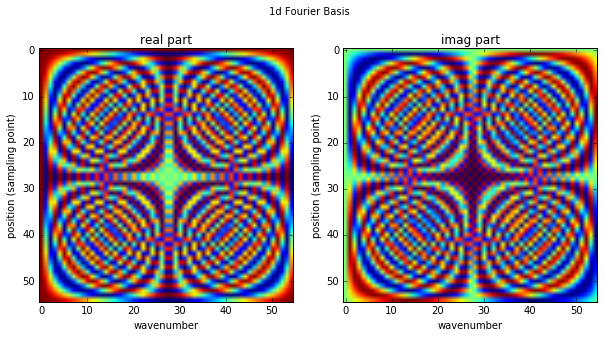

In [306]:
def get_1dfourier_basis(nx):
    ks = np.arange(nx)
    ns = np.arange(nx)
    basis = 1./np.sqrt(nx) * np.exp(-2j * np.pi * ks[None, :] * ns[:, None] / float(nx))
    return basis

fbasis = get_1dfourier_basis(nx)

# plot cosine (real part) and sine (imaginary part) of the Fourier Basis
fig, (col1, col2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('1d Fourier Basis')
col1.imshow(fbasis.real)
col1.set(title='real part', xlabel='wavenumber', ylabel='position (sampling point)')
col2.imshow(fbasis.imag)
col2.set(title='imag part', xlabel='wavenumber', ylabel='position (sampling point)')

The matrix can be diagonalized by:

$$C_\textrm{diagonal} = \mathbf{U}^T \mathbf{C} \mathbf{U}$$

Indeed, as shown in the plots, the covariance matrices are nicely concentrated around the diagonal. As we would expect, only the circulant covariance matrix is perfectly diagonalized by the Fourier basis, as it corresponds to periodic boundary conditions. However, also the non-circulant matrix can be reasonably well diagonalized by the Fourier basis. Differences appear mostly at the high-frequency cutoff, as we would expect.

As a consequence, the Eigenvalue spectra can also be very well predicted in both cases by the Fourier spectrum (Szegö's Theorem). In the periodic case, the numeric eigenspectrum corresponds perfectly to the Fourier spectrum,
however, due to the introduced periodicity, the Bessel function no longer corresponds to a true covariance function, such that we introduce negative eigenvalues. A possibility to generate a periodic true covariance matrix is to filter out the negative part of the spectrum.

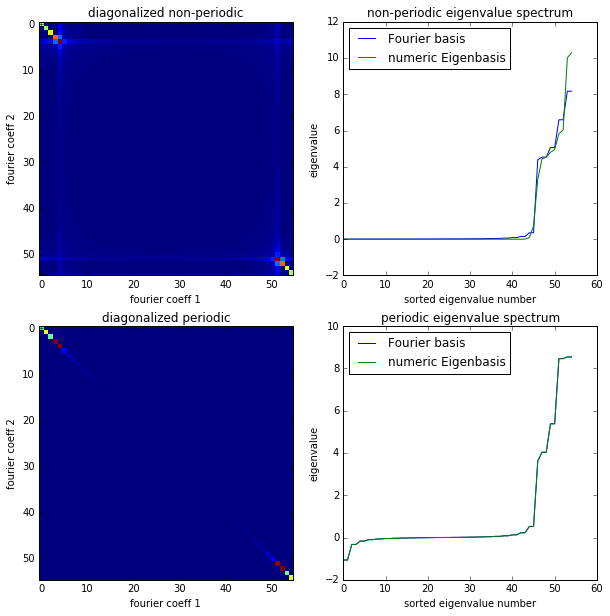

In [307]:
# diagonalize covariance matrices and extract the sorted diagonal entries
diagonalized = fbasis.dot(covariance).dot(fbasis.conjugate().T)
diagonalized_circ = fbasis.dot(covariance_circ).dot(fbasis.conjugate().T)

evals_ana = np.sort(np.real(np.diag(diagonalized)))
evals_ana_circ = np.sort(np.real(np.diag(diagonalized_circ)))

fig, axes = plt.subplots(2, 2, figsize=(10,10))

# plot non-periodic diagonalized matrix and eigenvalue spectra
axes[0, 0].imshow(np.abs(diagonalized), interpolation='nearest')
axes[0, 0].set(title='diagonalized non-periodic', xlabel='fourier coeff 1', ylabel='fourier coeff 2')
axes[0, 1].plot(evals_ana, label='Fourier basis')
axes[0, 1].plot(evals, label='numeric Eigenbasis')
axes[0, 1].set(title='non-periodic eigenvalue spectrum', xlabel='sorted eigenvalue number', ylabel='eigenvalue')
axes[0, 1].legend(loc=2)

# plot periodic diagonalized matrix and eigenvalue spectra
axes[1, 0].imshow(np.abs(diagonalized_circ), interpolation='nearest')
axes[1, 0].set(title='diagonalized periodic', xlabel='fourier coeff 1', ylabel='fourier coeff 2')
axes[1, 1].plot(evals_ana_circ, label='Fourier basis')
axes[1, 1].plot(evals_circ, label='numeric Eigenbasis')
axes[1, 1].set(title='periodic eigenvalue spectrum', xlabel='sorted eigenvalue number', ylabel='eigenvalue')
axes[1, 1].legend(loc=2)

## the 2d case: block toeplitz and block circulant matrices

A 2d covariance matrix on a regular grid can be written as C(x, x', y, y'). Such a matrix can be displayed in terms of 2 indices by using 2 multiindices. E.g. i = (x, x') and j = (y, y'), or i = (x, y) and j = (x', y'), etc...
The Resulting 2d covariance matrix gets a block form. Where the block number is given by the first index of i,j and the position within a block by the second index of i,j.

We again initialize periodic and non-periodic covariance matrices in 2 dimensions in the following cell and show different arangement possibilities

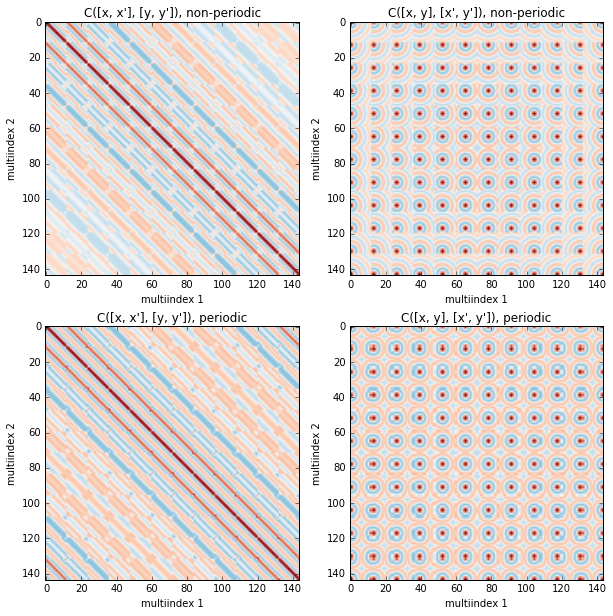

In [319]:
def get_2dcovariance_matrix(nx, ny, frequency, boundary=None):
    width = 1.
    height = 1.
    x = np.arange(0., width, 1./nx)
    y = np.arange(0., height, 1./ny)
    xgrid, ygrid = np.meshgrid(x, y, indexing='ij')
    dxs = np.abs(xgrid[:, :, None, None] - xgrid[None, None, :, :])
    dys = np.abs(ygrid[:, :, None, None] - ygrid[None, None, :, :])
    if boundary == 'periodic':
        iwrapx = dxs > width/2.
        dxs[iwrapx] = width - dxs[iwrapx]
        iwrapy = dys > width/2.
        dys[iwrapy] = width - dys[iwrapy]
    distances = np.sqrt(dxs**2 + dys**2).reshape(nx * ny, nx * ny)
    covariance = jn(0, frequency * distances)
    return covariance

# get covariance matrices
nx = 12
ny = 12
npts = nx * ny
frequency = 15
covariance2d = get_2dcovariance_matrix(nx, ny, frequency)
covariance2d_new = covariance2d.reshape(nx, nx, ny, ny).transpose((0, 2, 1, 3)).reshape(nx * nx, ny * ny)

covariance_circ2d = get_2dcovariance_matrix(nx, ny, frequency, boundary='periodic')
covariance_circ2d_new = covariance_circ2d.reshape(nx, ny, nx, ny).transpose((0, 2, 1, 3)).reshape(nx * nx, ny * ny)

# plot non-periodic covariance matrix and its eigenvalues/vectors
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(covariance2d, norm=norm_bessel, cmap='RdBu_r')
axes[0, 0].set(title="C([x, x'], [y, y']), non-periodic", xlabel='multiindex 1', ylabel='multiindex 2')
axes[0, 1].imshow(covariance2d_new, norm=norm_bessel, cmap='RdBu_r')
axes[0, 1].set(title="C([x, y], [x', y']), non-periodic", xlabel='multiindex 1', ylabel='multiindex 2')

# plot periodic covariance matrix and its eigenvalues/vectors
axes[1, 0].imshow(covariance_circ2d, norm=norm_bessel, cmap='RdBu_r')
axes[1, 0].set(title="C([x, x'], [y, y']), periodic", xlabel='multiindex 1', ylabel='multiindex 2')
axes[1, 1].imshow(covariance_circ2d_new, norm=norm_bessel, cmap='RdBu_r')
axes[1, 1].set(title="C([x, y], [x', y']), periodic", xlabel='multiindex 1', ylabel='multiindex 2')

as in the 1d case, the matrices can be decomposed into their eigenbasis.

[(0, 144),
 (0, 144),

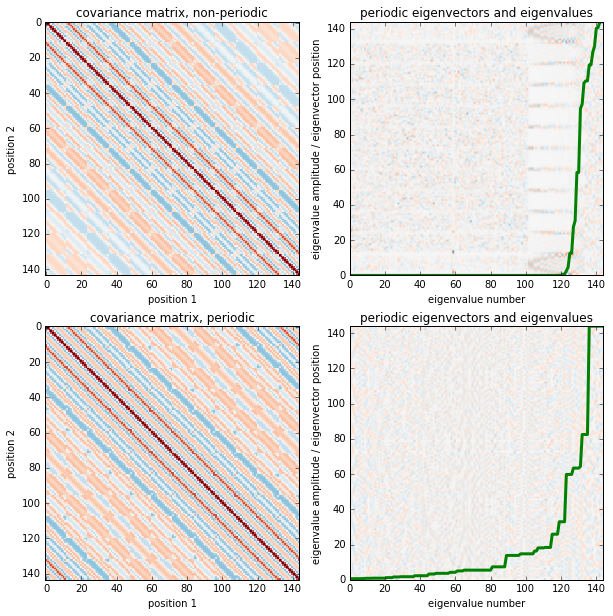

In [320]:
evals2d, evecs2d = np.linalg.eigh(covariance2d)
evals2dabs = np.sort(np.abs(evals2d))

evals_circ2d, evecs_circ2d = np.linalg.eigh(covariance_circ2d)
evals_circ2dabs = np.sort(np.abs(evals_circ2d))

norm_evecs = plt.Normalize(-3./np.sqrt(nx), 3./np.sqrt(nx))
norm_bessel = plt.Normalize(-1, 1)

# plot non-periodic covariance matrix and its eigenvalues/vectors
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(covariance2d, norm=norm_bessel, cmap='RdBu_r', interpolation='nearest')
axes[0, 0].set(title='covariance matrix, non-periodic', xlabel='position 1', ylabel='position 2')
axes[0, 1].imshow(evecs2d, origin='lower', aspect='auto', extent=(0, npts, 0, npts),
                  cmap='RdBu', norm=norm_evecs)
axes[0, 1].plot(evals2dabs / evals2dabs.max() * npts, c='green', lw=3)
axes[0, 1].set(title='periodic eigenvectors and eigenvalues', xlim=(0, npts), ylim=(0, npts),
               xlabel='eigenvalue number', ylabel='eigenvalue amplitude / eigenvector position')

# plot periodic covariance matrix and its eigenvalues/vectors
axes[1, 0].imshow(covariance_circ2d, norm=norm_bessel, cmap='RdBu_r', interpolation='nearest')
axes[1, 0].set(title='covariance matrix, periodic', xlabel='position 1', ylabel='position 2')
axes[1, 1].imshow(evecs_circ2d, origin='lower', aspect='auto', extent=(0, npts, 0, npts),
                  cmap='RdBu', norm=norm_evecs)
axes[1, 1].plot(evals_circ2dabs / evals_circ2dabs.max() * npts, c='green', lw=3)
axes[1, 1].set(title='periodic eigenvectors and eigenvalues', xlim=(0, npts), ylim=(0, npts),
               xlabel='eigenvalue number', ylabel='eigenvalue amplitude / eigenvector position')

We now construct the 2d Fourier basis.

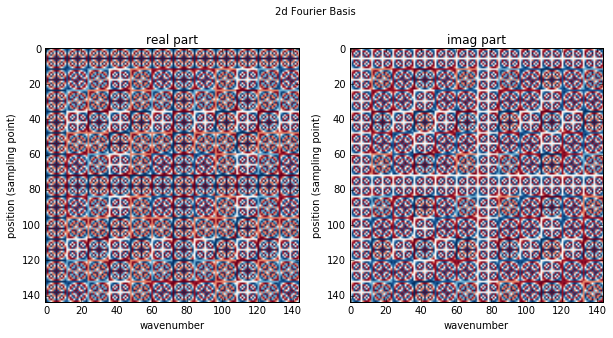

In [321]:
def get_2dfourier_basis(nx, ny):
    # 1) get x basis
    ks = np.arange(nx)
    ns = np.arange(nx)
    basisx = 1./np.sqrt(nx) * np.exp(-2j * np.pi * ks[None, :] * ns[:, None] / float(nx))
    # 2) get y basis
    ks = np.arange(ny)
    ns = np.arange(ny)
    basisy = 1./np.sqrt(ny) * np.exp(-2j * np.pi * ks[None, :] * ns[:, None] / float(ny))
    # 3) outer product of both bases yields: U(kx, ky, x, y)
    basis = basisx[:, None, :, None] * basisy[None, :, None, :]
    return basis.reshape(nx * ny, nx * ny)

fbasis2d = get_2dfourier_basis(nx, ny)

# plot cosine (real part) and sine (imaginary part) of the Fourier Basis
fig, (col1, col2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('2d Fourier Basis')
col1.imshow(fbasis2d.real, cmap='RdBu', vmin=-1./np.sqrt(npts), vmax=1./np.sqrt(npts))
col1.set(title='real part', xlabel='wavenumber', ylabel='position (sampling point)')
col2.imshow(fbasis2d.imag, cmap='RdBu', vmin=-1./np.sqrt(npts), vmax=1./np.sqrt(npts))
col2.set(title='imag part', xlabel='wavenumber', ylabel='position (sampling point)')

Diagonalization

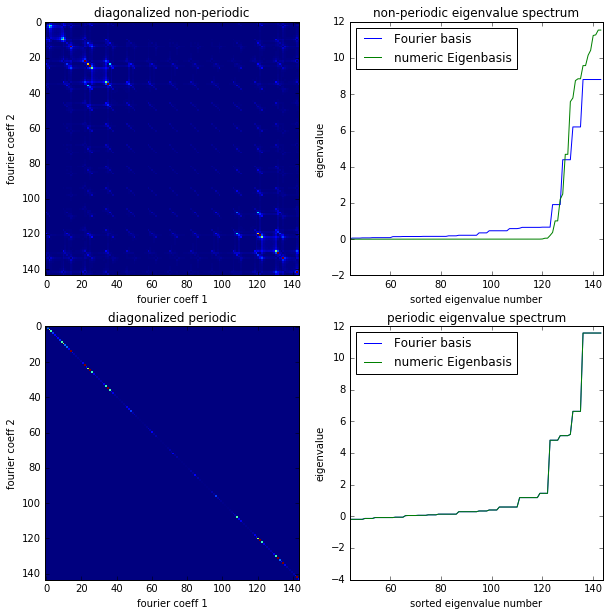

In [322]:
# diagonalize covariance matrices and extract the sorted diagonal entries
diagonalized2d = fbasis2d.dot(covariance2d).dot(fbasis2d.conjugate().T)
diagonalized_circ2d = fbasis2d.dot(covariance_circ2d).dot(fbasis2d.conjugate().T)

evals_ana2d = np.sort(np.real(np.diag(diagonalized2d)))
evals_ana_circ2d = np.sort(np.real(np.diag(diagonalized_circ2d)))

fig, axes = plt.subplots(2, 2, figsize=(10,10))

# plot non-periodic diagonalized matrix and eigenvalue spectra
axes[0, 0].imshow(np.abs(diagonalized2d), interpolation='nearest')
axes[0, 0].set(title='diagonalized non-periodic', xlabel='fourier coeff 1', ylabel='fourier coeff 2')
axes[0, 1].plot(evals_ana2d, label='Fourier basis')
axes[0, 1].plot(evals2d, label='numeric Eigenbasis')
axes[0, 1].set(title='non-periodic eigenvalue spectrum', xlabel='sorted eigenvalue number', ylabel='eigenvalue',
               xlim=(npts - 100, npts))
axes[0, 1].legend(loc=2)

# plot periodic diagonalized matrix and eigenvalue spectra
axes[1, 0].imshow(np.abs(diagonalized_circ2d), interpolation='nearest')
axes[1, 0].set(title='diagonalized periodic', xlabel='fourier coeff 1', ylabel='fourier coeff 2')
axes[1, 1].plot(evals_ana_circ2d, label='Fourier basis')
axes[1, 1].plot(evals_circ2d, label='numeric Eigenbasis')
axes[1, 1].set(title='periodic eigenvalue spectrum', xlabel='sorted eigenvalue number', ylabel='eigenvalue',
               xlim=(npts - 100, npts))
axes[1, 1].legend(loc=2)